# Technical task - BBC data set

We are going to build a classifier that categorize BBC articles into 5 different topics/classes: Politics, business, sport, entertainment and techology. We will use 2225 documents from the BBC news website to train and test an algorithm.

The data can be downloaded from this website: http://mlg.ucd.ie/datasets/bbc.html We are going to use the Dataset: BBC in raw format.

Firstly we will prepare the data to be ingested by the ML algorithm, afterwords we will train the models and finally we will evaluate the performance.

We have also explored the use of LDA for the extraction of natural topics in this dataset.

# 1. Data preparation

In [ ]:
#If not installed uncomment
#!pip install spacy 

In [5]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.7 MB 13.2 MB/s eta 0:00:01   |████████████▎                   | 5.3 MB 7.2 MB/s eta 0:00:02     |████████████████                | 6.9 MB 7.2 MB/s eta 0:00:01     |███████████████████▉            | 8.5 MB 7.2 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from zipfile import ZipFile
with ZipFile('bbc-fulltext.zip', 'r') as zipObj: 
   zipObj.extractall()

In [2]:
import spacy
import os
import pandas as pd
from __future__ import division

In [ ]:
nlp = spacy.load('en_core_web_sm')

text = u"This is first sentence. Second sentence. Third sentence."
text_sentences = nlp(text)
for sentence in text_sentences.sents:
    print(sentence.text)

This is first sentence.
Second sentence.
Third sentence.


In [ ]:

doc = nlp(u'I am Clara and this is the NLP class')
for token in doc:
     print(token.text, token.lemma_, token.is_stop, token.pos_)

(u'I', u'-PRON-', True, u'PRON')
(u'am', u'be', True, u'VERB')
(u'Clara', u'Clara', False, u'PROPN')
(u'and', u'and', True, u'CCONJ')
(u'this', u'this', True, u'DET')
(u'is', u'be', True, u'VERB')
(u'the', u'the', True, u'DET')
(u'NLP', u'NLP', False, u'PROPN')
(u'class', u'class', False, u'NOUN')


In [10]:
# function that loops through the directories that contain the files. Read them, extract the topic/class from the name of each folder
# and returns a dataframe

def extract_articles(path):
#rootdir = 
    cat_article=[]
    for subdir, dirs, files in os.walk(path):
        print(subdir)
        for file in files:
            if '.txt' in file:      
                category= subdir.split('/')[-1]
                f=open(os.path.join(subdir, file),'r',encoding='utf-8',errors='ignore')
                lines=f.readlines()
                lines=' '.join(lines).replace('\n','')
                #list of lists: [category,article]
                cat_article.append([category,lines])
                f.close()
    # we convert the list of lists [category, article] into a pandas dataframe            
    data=pd.DataFrame(cat_article)
    data.columns=['category','article']
    return data

In [11]:
#data=extract_articles('/content/drive/MyDrive/BBC_articles/articles')
data = extract_articles('./bbc')
data.head(10)

./bbc
./bbc/business
./bbc/entertainment
./bbc/politics
./bbc/sport
./bbc/tech


,category,article
0,business,Ad sales boost Time Warner profit Quarterly p...
1,business,Dollar gains on Greenspan speech The dollar h...
2,business,Yukos unit buyer faces loan claim The owners ...
3,business,High fuel prices hit BA's profits British Air...
4,business,Pernod takeover talk lifts Domecq Shares in U...
5,business,Japan narrowly escapes recession Japan's econ...
6,business,Jobs growth still slow in the US The US creat...
7,business,"India calls for fair trade rules India, which..."
8,business,Ethiopia's crop production up 24% Ethiopia pr...
9,business,Court rejects $280bn tobacco case A US govern...


In [ ]:
data.groupby('category').size()

category
business         510
entertainment    386
politics         417
sport            511
tech             401
dtype: int64

Number of articles per class. The number of samples per class is quite balanced

We are going to use a library for NLP called spacy. 
We need to convert the text into unicode format to be used by the library.

In [ ]:
data['article'] = data['article'].apply(lambda x: x.decode('utf-8','ignore'))

In [ ]:
pd.set_option('display.max_colwidth', -1)


In [ ]:
# we load english language to use spacy library and define functions that help us tokenize, 
# lemmatize the words of the articles and remove stop words.

nlp = spacy.load('en')

def punct_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """
    return token.is_punct or token.is_space

def lemmatize(doc):
    """
    function that tokenize the text, lemmatizes it and removes stop words.
    """
    parsed_doc=nlp(doc)
    lemm_doc = [token.lemma_ for token in parsed_doc
                      if not punct_space(token) and (token.lemma_!= '-PRON-') and not(nlp.vocab[token.text].is_stop)]
      
    # write the transformed text
    clean_text = u' '.join(lemm_doc)
    return clean_text

In [ ]:
# we apply the lemmatization to all articles

data['article_lemmatized']=data.article.map(lemmatize)

In [ ]:
# Types of categories
print "categories: \n",set(data.category)


categories: 
set(['politics', 'sport', 'tech', 'business', 'entertainment'])


In [ ]:
data[['category','article_lemmatized']].head(10)

,category,article_lemmatized
0,business,ad sale boost time warner profit quarterly pro...
1,business,dollar gain greenspan speech dollar hit high l...
2,business,yukos unit buyer face loan claim owner embattl...
3,business,high fuel price hit ba 's profit british airwa...
4,business,pernod takeover talk lift domecq share uk drin...
5,business,japan narrowly escape recession japan 's econo...
6,business,jobs growth slow create few job expect january...
7,business,india call fair trade rule india attend g7 mee...
8,business,ethiopia 's crop production 24% ethiopia produ...
9,business,court reject $ 280bn tobacco case government c...


Split the data into train and test sets for the machine learning algorithm 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split


In [ ]:
data['article_lemmatized'].shape

(2225,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['article_lemmatized'], data['category'], test_size=0.4, random_state=42)
print "size of training",len(X_train)
print "size of test",len(X_test)

size of training 1335
size of test 890


We need to convert the text into a format that can be ingested by the algorithm. We use CountVectorizer to convert the collection of articles to a matrix of token counts. It will produce a matrix in compressed sparse row format.

In [ ]:
cvec = CountVectorizer(stop_words='english', min_df=3)

# we create a matrix for the training set
cvec.fit(X_train)
cvec_counts_train = cvec.transform(X_train)
# we create a matrix for the test set
cvec_counts_test=cvec.transform(X_test)

Some info about the matrix of training set in compressed sparse row format

In [ ]:
print 'sparse matrix shape:', cvec_counts_train.shape
print 'nonzero count:', cvec_counts_train.nnz
print 'sparsity: %.2f%%' % (100.0 * cvec_counts_train.nnz / (cvec_counts_train.shape[0] * cvec_counts_train.shape[1]))

sparse matrix shape: (1335, 7702)
nonzero count: 163747
sparsity: 1.59%


Instead of using word frequency alone we use tf/idf metric, which represents how important a word is to a document in a collection of corpus. It penalises words that tend to appear in all documents.

In [ ]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(cvec_counts_train)
X_test_tfidf = tfidf_transformer.fit_transform(cvec_counts_test)

Now the data is ready to be ingested by a ML alforithm

# 2. Machine learning algorithm

The problem we are facing is a multi-class classification problem. We are going to try 2 ml algorithms: random forest and multinomial naive bayes.

# 2.1 Random forest:

Random forest classifier is an ensemble classification method that consists of training several decission trees
on different subsamples of the data taking different subsets of features. The output class is selected by majority vote of the classes provided by all the trees.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn import metrics

# training
clf = RandomForestClassifier().fit(X_train_tfidf, y_train)

# testing
predicted=clf.predict(X_test_tfidf)

How accurate is the model? We can calculate the global accuracy

In [ ]:
metrics.accuracy_score(y_test, predicted)

0.9168539325842696

We compute also other metrics for each class to evaluate the model like precision, recall or f1-score. We see that the precision is high: 0.91 in average and we can observe in the table bellow which is the precission, recall and f1-score for each class to evaluate how the model performs in classifying samples from each class.

In [ ]:
print(metrics.classification_report(y_test, predicted))

               precision    recall  f1-score   support

     business       0.82      0.96      0.88       203
entertainment       0.96      0.85      0.90       157
     politics       0.94      0.90      0.92       167
        sport       0.94      0.97      0.96       210
         tech       0.99      0.87      0.92       153

    micro avg       0.92      0.92      0.92       890
    macro avg       0.93      0.91      0.92       890
 weighted avg       0.92      0.92      0.92       890



But this evaluation has been performed over one training and test data set chosen randomly. In order to be able to evaluate the performance of the model in a general basis we need to perform k-fold cross validation, which consists of partitioning the dataset in k subsets and using k-1 subsets for training and the one remaining for test and repeat this process until all the subsets has been used for testing.

In order to make the count_vectorizer, tfidf-transformer, classifier easier to work with, 
scikit-learn provides a Pipeline class that helps run all the process together:

In [ ]:
from sklearn.pipeline import Pipeline

text_clf = Pipeline([('vect', CountVectorizer(stop_words='english', min_df=3)),\
                     ('tfidf', TfidfTransformer()),\
                     ('clf', RandomForestClassifier())])

In [ ]:
#Description of steps of pipeline
text_clf.steps

[('vect',
  CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
          dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
          lowercase=True, max_df=1.0, max_features=None, min_df=3,
          ngram_range=(1, 1), preprocessor=None, stop_words='english',
          strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
          tokenizer=None, vocabulary=None)),
 ('tfidf', TfidfTransformer(norm=u'l2', smooth_idf=True, sublinear_tf=False,
           use_idf=True)),
 ('clf',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False))]

In [ ]:
text_clf.fit(X_train, y_train)  

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
     ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [ ]:
from sklearn.model_selection import cross_val_score

#cross_val_score evaluates a score by cross-validation. k-folds= parameter cv
kfold_acc = cross_val_score(text_clf,data['article_lemmatized'], data['category'],cv=10,
    scoring='accuracy')

print "mean accuracy with 10-fold cross validation:", kfold_acc.mean()

mean accuracy with 10-fold cross validation: 0.9231508117089758


We can also extract what are the words that are more critical in differentiating the classes:

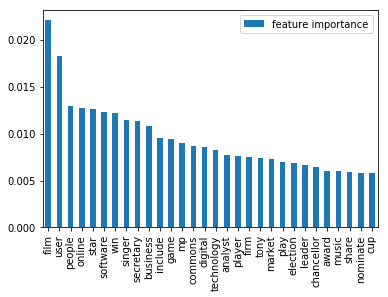

In [ ]:
feat_imp=list(text_clf.steps[2][1].feature_importances_)
features=text_clf.steps[0][1].get_feature_names()
result=pd.DataFrame(feat_imp,features)
result.columns=(['feature importance'])

%matplotlib inline

result.sort_values(['feature importance'],ascending=False).head(30).plot(kind='bar')

There are some parameters that affect the performance of random forest like the number of trees used, the number of predictors/features that random forest is allowed to try in each split (max_features), also the min_sample_leaf is the minimum number of samples required in one leaf. Leaf is the end node of a decision tree, a smaller leaf can make the model capture noise in train data.

Let's change the number of trees (n_estimators parameter) and see if the results improve:

In [ ]:
text_clf2 = Pipeline([('vect', CountVectorizer(stop_words='english', min_df=3)),\
                     ('tfidf', TfidfTransformer()),\
                     ('clf', RandomForestClassifier(n_estimators=100))])

text_clf2.fit(X_train, y_train)

#cross_val_score evaluates a score by cross-validation. k-folds= parameter cv
kfold_acc2 = cross_val_score(text_clf2,data['article_lemmatized'], data['category'],cv=10,
    scoring='accuracy')

print "mean accuracy with 10-fold cross validation:", kfold_acc2.mean()

mean accuracy with 10-fold cross validation: 0.96220978684181


We observe that the performance has improved after changing the number of trees.


We can also optimize the performance of the model by using grid search. With grid search we can select different values for the parameters and the function will return the set of parameters that make the model perform better in the metric chosen. In the example above we choose accuracy.

In [ ]:
from sklearn.model_selection import GridSearchCV

# use a full grid over all parameters
param_grid = {"clf__n_estimators": [100,150],
              "clf__max_features": ['auto','sqrt',0.2],
              "clf__min_samples_leaf": [2, 3, 50],
              "clf__criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(text_clf2, param_grid=param_grid, scoring='accuracy')
start = time()
grid_search.fit(X_train, y_train)



{'clf__criterion': 'gini', 'clf__max_features': 'sqrt', 'clf__n_estimators': 150, 'clf__min_samples_leaf': 2}


In [ ]:
print 'best parameters values:\n',grid_search.best_params_
print
#Mean cross-validated score of the best_estimator
print 'best score:\n',grid_search.best_score_

best parameters values:
{'clf__criterion': 'gini', 'clf__max_features': 'sqrt', 'clf__n_estimators': 150, 'clf__min_samples_leaf': 2}

best score:
0.960299625468



What we can infere from the results obtained using random forest is that the features selected for the classification, in this case the word counts or their equivalent tf/idf values are clearly discriminant between the 5 classes.


Although Random Forest is performing very well in this case, usually Random Forest does not necessarily work well with sparse matrix such as the ones used in text classification. 



Another model that is frequently used in text classification is multinomial naive bayes. We will try it.


# 2.2 Multinomial naive bayes

Naive Bayes is a probabilistic method that assumes independence between the features in our case the words in the vocabulary of the corpus of articles.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#In order to make the vectorizer => transformer => classifier easier to work with, 
#scikit-learn provides a Pipeline class that behaves like a compound classifier:

text_clf_nb = Pipeline([('vect', CountVectorizer(stop_words='english', min_df=3)),\
                     ('tfidf', TfidfTransformer()),\
                     ('clf', MultinomialNB())])

In [ ]:
text_clf_nb.fit(X_train, y_train)  
predicted = text_clf_nb.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, predicted))

               precision    recall  f1-score   support

     business       0.94      1.00      0.97       203
entertainment       0.99      0.92      0.95       157
     politics       0.94      0.95      0.94       167
        sport       1.00      1.00      1.00       210
         tech       0.97      0.96      0.97       153

    micro avg       0.97      0.97      0.97       890
    macro avg       0.97      0.96      0.97       890
 weighted avg       0.97      0.97      0.97       890



In [ ]:
# Saving the model
from sklearn.externals import joblib
joblib.dump(text_clf_nb, 'text_clf_nb.pkl') 

k-fold cross validation

In [ ]:
#cross_val_score evaluates a score by cross-validation. k-folds= parameter cv

kfold_acc_nb = cross_val_score(text_clf_nb,X_train,y_train,cv=10,
    scoring='accuracy')

print "mean accuracy with 10-fold cross validation:", kfold_acc_nb.mean()



mean accuracy with 10-fold cross validation: 0.968534738733


We observe that the accuracy is similar to random forest, slightly higher with the multinomial naive bayes classifier (NBC). We can then assert that for this particular problem both methods perform really well. 

Something worth mentioning is that the speed of NBC is greater than RF, which can be of importance in case there is a need of escalating the problem to a larger number of articles.

One of the things that we could have used is ngrams of 2 or 3 words as features for the model. To test this, tests have been performed adding the parameter: ngram_range=(1,3) and ngram_range=(1,2) to the CountVectorizer function but the peformance did not improve.


# One step more of validation

It is always good to validate the performance of a model with a validation dataset. We can obtain a validation dataset using the second dataset in http://mlg.ucd.ie/datasets/bbc.html that contains articles from BBC Sports labeled with sport categories.

We can use this dataset to validate the model.

In [ ]:
sports=extract_articles('/content/drive/MyDrive/BBC_articles/bbcsport')

In [ ]:
sports.head()

,category,article
0,athletics,Claxton hunting first major medal British hur...
1,athletics,O'Sullivan could run in Worlds Sonia O'Sulliv...
2,athletics,Greene sets sights on world title Maurice Gre...
3,athletics,IAAF launches fight against drugs The IAAF - ...
4,athletics,"Dibaba breaks 5,000m world record Ethiopia's ..."


In [ ]:
print 'sports categories:',set(sports.category)


sports categories: set(['tennis', 'athletics', 'football', 'rugby', 'cricket'])


Text cleaning


In [ ]:
# converting to unicode
sports['article'] = sports['article'].apply(lambda x: x.decode('utf-8','ignore'))

# lemmatization
sports['article_lemmatized']=sports.article.map(lemmatize)

It could be that some sport articles in the training dataset are contained in the sports dataset. In order to avoid having articles in the validation dataset that have been used for training in the previous steps we exclude those articles that appear in both. 

In [ ]:
print 'number of sports articles in the whole dataset:',data[data['category']=='sport'].shape[0]
print 'number of articles in the sports dataset',sports.shape[0]

number of sports articles in the whole dataset: 511
number of articles in the sports dataset 737


In [ ]:
#concatenate the two dataframes and remove the duplicates
concat=pd.concat([data[data.category=='sport'][['category','article','article_lemmatized']],sports[['category','article','article_lemmatized']]])

unique_sport=concat[(concat.duplicated(subset=['article'])==False)&(concat.category!='sport')]
print 'number of articles not used in the training:',unique_sport.shape[0]

number of articles not used in the training: 222


In [ ]:
#predict the class with the multinomial naive Bayes trained classifier

predicted=text_clf_nb.predict(unique_sport['article_lemmatized'])

#accuracy: number of articles labeled with sport
print 'accuracy of the model:',list(predicted).count('sport')/len(predicted)


accuracy of the model: 0.945945945946


We can confirm that the model works well also for this validation dataset

# Example of prediction

In [ ]:
#we select one article of the test set
ind1=X_test.index[400]
data.article[ind1]

u'Beckham virus spotted on the net  Virus writers are trading on interest in David Beckham to distribute their malicious wares.  Messages are circulating widely that purport to have evidence of the England captain in a compromising position. But anyone visiting the website mentioned in the message will not see pictures of Mr Beckham but will have their computer infected by a virus. The pernicious program opens a backdoor on a computer so it can be controlled remotely by malicious hackers.  The appearance of the Beckham Windows trojan is just another example in a long line of viruses that trade on interest in celebrities in an attempt to fuel their spread. Tennis player Anna Kournikova, popstars Britney Spears and Avril Lavigne as well as Arnold Schwarzenegger have all been used in the past to try to con people into opening infected files. The huge amount of interest in Mr Beckham and his private life and the large number of messages posted to discussion groups on the net might mean tha

In [ ]:
class_=text_clf_nb.predict([data.article[ind1]])[0]
print "the predicted class is:",class_ , "\nand the true one was:",data['category'][ind1]


the predicted class is: tech 
and the true one was: tech


Another example:

In [ ]:
#we select one article of the test set
ind1=X_test.index[800]
data.article[ind1]


u"Millions go missing at China bank  Two senior officials at one of China's top commercial banks have reportedly disappeared after funds worth up to $120m (\xa364m) went missing.  The pair both worked at Bank of China in the northern city of Harbin, the South China Morning Post reported. The latest scandal at Bank of China will do nothing to reassure foreign investors that China's big four banks are ready for international listings. Government policy sees the bank listings as vital economic reforms. Bank of China is one of two frontrunners in the race to list overseas. The other is China Construction Bank. Both are expected to list abroad during 2005.  They shared a $45bn state bailout in 2003, to help clean up their balance sheets in preparation for a foreign stock market debut.  However, a report in the China-published Economic Observer said on Monday that the two banks may have scrapped plans to list in New York because of the cost of meeting regulatory requirements imposed since th

In [ ]:
class_=text_clf_nb.predict([data.article[ind1]])[0]
print "the predicted class is:",class_ , "\nand the true one was:",data['category'][ind1]


the predicted class is: business 
and the true one was: business


# What else can we extract from this dataset?

We have built supervised learning models that learn to classify articles into predefined categories. Now we can try to extract natural topics within the articles. We explore now how the unsupervised learning algorithm LDA can help us. LDA is a generative probabilistic model that needs to know the number of topics a priori. It assigns a probability to each word in the corpus of documents to belong to a topic. This way we can find groups of words that tend to appear in certain groups of articles.

# LDA - topic modelling

In [ ]:
import gensim
from gensim.corpora import Dictionary, MmCorpus
#from gensim.models.ldamulticore import LdaMulticore
from gensim.models.phrases import Phraser
from gensim.models import Phrases, LdaModel
#from gensim.models.word2vec import LineSentence

import pyLDAvis
import pyLDAvis.gensim
import warnings
import cPickle as pickle



In [ ]:
#The function Dictionary creates a dictionary of terms from the docs. It needs as input a list of list of tokens.
#We need to split the documents into lists of words

splitter = lambda x: x.split()
doc_list=data.article_lemmatized.apply(splitter)
# Phrases identifies multi word expressions co-ocurring in multiple docs (n-grams)
phrases = Phrases(doc_list)
# Phraser replace the n-grams found in the documents
bigrams = Phraser(phrases)
# creation of the dictionary for LDA input
dic= Dictionary(doc_list)

In [ ]:
dic.filter_extremes(no_below=1)#, no_above=0.8)

This is an exploratory phase so we select 20 topics.

In [ ]:
#use the dictionary to create a document-term matrix
corpus = [dic.doc2bow(doc) for doc in doc_list]

lda_model = LdaModel(corpus, num_topics=20, id2word=dic, update_every=1, chunksize=1000, passes=50)
lda_model.save('lda_model')

In [ ]:
# load model in order not to retrain
lda_model = gensim.models.ldamodel.LdaModel.load('lda_model')

In [ ]:
lda_model.show_topic(topicid=10)

In [ ]:
# we retrieve the 15 words with the highest probability to belong to each topic
topic_words=lda_model.print_topics(num_words=15)
topics=[]
for topic in topic_words:
    topics.append( topic[1].split('+'))

pd.DataFrame(topics).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,"0.012*""india""","0.013*""dollar""","0.014*""be""","0.038*""mobile""","0.071*""game""","0.027*""mr""","0.017*""tv""","0.037*""mac""","0.027*""film""","0.012*""$""","0.018*""win""","0.060*""g""","0.016*""file""","0.017*""be""","0.017*""digital""","0.034*""good""","0.015*""wales""","0.013*""fraud""","0.014*""net""","0.015*""m"""
1,"0.012*""protocol""","0.012*""bush""","0.011*""play""","0.035*""phone""","0.020*""gaming""","0.012*""government""","0.014*""game""","0.013*""hunt""","0.014*""music""","0.010*""£""","0.016*""6""","0.055*""3""","0.013*""system""","0.013*""people""","0.016*""music""","0.021*""win""","0.014*""england""","0.012*""guilty""","0.014*""user""","0.015*""£"""
2,"0.011*""indian""","0.011*""deficit""","0.009*""player""","0.014*""people""","0.016*""dvd""","0.010*""party""","0.012*""high""","0.011*""light""","0.013*""star""","0.009*""market""","0.015*""m""","0.020*""seed""","0.010*""apple""","0.010*""not""","0.014*""service""","0.017*""award""","0.013*""ireland""","0.010*""deutsche""","0.012*""mail""","0.010*""coach"""
3,"0.010*""systems""","0.009*""growth""","0.009*""game""","0.011*""technology""","0.015*""play""","0.010*""labour""","0.012*""device""","0.009*""mr""","0.010*""include""","0.009*""m""","0.011*""world""","0.020*""7""","0.010*""legal""","0.010*""work""","0.014*""technology""","0.013*""film""","0.011*""half""","0.010*""lse""","0.012*""virus""","0.008*""mr"""
4,"0.009*""telekom""","0.009*""figure""","0.008*""not""","0.011*""use""","0.011*""title""","0.010*""election""","0.011*""sony""","0.008*""keyboard""","0.010*""band""","0.008*""company""","0.011*""final""","0.010*""hsdpa""","0.009*""company""","0.009*""time""","0.014*""people""","0.008*""v""","0.011*""rugby""","0.009*""exchange""","0.011*""e""","0.006*""$"""
5,"0.009*""boeing""","0.009*""sale""","0.008*""club""","0.009*""service""","0.011*""player""","0.008*""minister""","0.010*""console""","0.008*""hunting""","0.009*""uk""","0.007*""rise""","0.011*""set""","0.010*""speed""","0.009*""software""","0.009*""like""","0.012*""broadband""","0.007*""actor""","0.009*""france""","0.009*""london""","0.011*""site""","0.006*""work"""
6,"0.008*""austria""","0.007*""economy""","0.007*""time""","0.008*""camera""","0.011*""world""","0.008*""blair""","0.009*""new""","0.008*""laser""","0.009*""number""","0.007*""bank""","0.010*""title""","0.009*""player""","0.009*""firm""","0.008*""think""","0.010*""player""","0.007*""director""","0.009*""minute""","0.009*""charge""","0.011*""search""","0.006*""week"""
7,"0.007*""plane""","0.007*""rise""","0.007*""team""","0.007*""handset""","0.010*""2""","0.007*""people""","0.009*""definition""","0.007*""silicon""","0.009*""award""","0.007*""share""","0.008*""open""","0.008*""second""","0.008*""law""","0.006*""world""","0.009*""gadget""","0.007*""british""","0.008*""try""","0.008*""executive""","0.010*""software""","0.005*""aid"""
8,"0.007*""tobacco""","0.006*""2004""","0.006*""come""","0.007*""company""","0.009*""online""","0.006*""plan""","0.009*""gamer""","0.007*""animal""","0.008*""m""","0.007*""firm""","0.008*""second""","0.008*""network""","0.008*""court""","0.006*""life""","0.009*""pc""","0.006*""prize""","0.008*""game""","0.008*""boerse""","0.010*""security""","0.005*""pension"""
9,"0.007*""flight""","0.006*""steam""","0.006*""go""","0.007*""device""","0.008*""release""","0.006*""tell""","0.008*""mr""","0.007*""vodafone""","0.008*""album""","0.007*""price""","0.008*""champion""","0.008*""mp3""","0.007*""network""","0.005*""go""","0.008*""consumer""","0.006*""star""","0.007*""squad""","0.007*""york""","0.009*""people""","0.005*""take"""


In [ ]:
#We use the model to classify the articles into the topic with highest probability

def return_topic(article):
    article_bow=dic.doc2bow(article.split())
    article_lda = lda_model[article_bow]
    article_lda
    #sorted sorts the elements of an iterable, in this case the iterable is a list of tuples (topic,probability/frequency) 
    #we order by frequency
    topics_sorted=sorted(article_lda, key=lambda (topic_number, freq): -freq)
    #topic with highest probability
    return topics_sorted[0][0]
    

In [ ]:
#new column with the topic
data['topic']=data.article_lemmatized.map(return_topic)

In [ ]:
# Number of articles per topic
data.topic.value_counts()

9     434
5     408
2     344
10    150
8     144
13    101
18     97
14     95
19     77
3      67
12     66
15     62
16     60
6      55
4      20
17     15
1      12
7      10
0       5
11      3
Name: topic, dtype: int64

In [ ]:
# examples of topics that can be found within the general categories

1 -> dollar, growth, deficit, economy, rise (business)
9 -> $,£, company, bank, firm (business)
3 -> mobile, phone (technology)
4 -> game, gaming (technology)
5 -> government, party, labour, election (politics)
18 -> mail, virus, software, security (technology)
8 -> film, music, star, award (enterteinment)

In [ ]:
# number of articles per topic that belong to each of the general categories

In [ ]:
data.groupby('topic').category.value_counts()

topic  category     
0      business         4  
       entertainment    1  
1      business         8  
       entertainment    4  
2      sport            292
       entertainment    34 
       business         10 
       politics         6  
       tech             2  
3      tech             54 
       business         11 
       entertainment    1  
       politics         1  
4      tech             17 
       entertainment    3  
5      politics         370
       entertainment    14 
       business         13 
       tech             8  
       sport            3  
6      tech             37 
       entertainment    13 
       business         3  
       politics         1  
       sport            1  
7      tech             8  
       entertainment    2  
8      entertainment    139
       tech             3  
       business         2  
                       ..  
11     tech             2  
       business         1  
12     tech             50 
       sport            8  

Examples of interesting topics broken down by general category. 

In [ ]:
# cybersecurity (mail, virus, user, site, security)

data.groupby('topic').category.value_counts()[18]

category
tech             94
business          2
entertainment     1
Name: category, dtype: int64

In [ ]:
#telephony (mobile,phone, camera)
data.groupby('topic').category.value_counts()[3]

category
tech             54
business         11
entertainment     1
politics          1
Name: category, dtype: int64

In [ ]:
#gaming
data.groupby('topic').category.value_counts()[4]

category
tech             17
entertainment     3
Name: category, dtype: int64

In [ ]:
#market ($,£, company, bank, firm)

data.groupby('topic').category.value_counts()[9]

category
business         403
politics          12
entertainment      9
tech               9
sport              1
Name: category, dtype: int64

In [ ]:
# business (dollar, growth, deficit, economy, rise)

data.groupby('topic').category.value_counts()[1]

category
business         8
entertainment    4
Name: category, dtype: int64

In [ ]:
#politics (government, party)
data.groupby('topic').category.value_counts()[5]

category
politics         370
entertainment    14 
business         13 
tech             8  
sport            3  
Name: category, dtype: int64

In [ ]:
# sport1 (play, game, team)
data.groupby('topic').category.value_counts()[2]

category
sport            292
entertainment    34 
business         10 
politics         6  
tech             2  
Name: category, dtype: int64

In [ ]:
#sport2 (win, final, champion)
data.groupby('topic').category.value_counts()[10]

category
sport            144
entertainment    3  
tech             3  
Name: category, dtype: int64

In [ ]:
#entertainment (film, music, star, award)
data.groupby('topic').category.value_counts()[8]

category
entertainment    139
tech             3  
business         2  
Name: category, dtype: int64

We have performed an initial exploration of what could be achieved with LDA. We have found topics within the general categories that can be useful to classify the text at a more granular level. One of the drawbacks of this algorithm is the fact that it needs a post-training human interpreation to interpret the topics. Also the number of topics needs to be defined a priori which is a common problem within the family of clustering algorithms.



In [ ]:
import os

os.system('jupyter nbconvert --to html technical_task_clara_higuera-submission.ipynb')

0